In [1]:
#Downloading the MNIST dataset from sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X,y = mnist['data'],mnist['target']
print(X.shape,y.shape)


(70000, 784) (70000,)


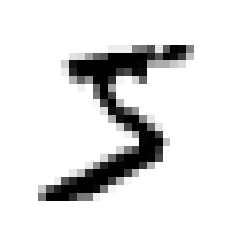

In [3]:
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [4]:
#converting all the labels to int
import numpy as np
y = y.astype(np.int8)

In [8]:
#The mnist dataset from sklearn is already split into training and testing data.
#where 60000 images are for training and the rest 10k are for testing
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#### Training a Binary Classifier
Here we just just train a model which detects only a single number which is just a binary classifier

In [10]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

#Stochastic gradient classifier which is good at handling large datasets
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

Evaluating the model with Cross-validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3,random_state = 42)


C:\Users\Chandra\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))
    

0.95035
0.96035
0.9604


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

From the above we can see that the base models such as the SGDclassifier performs when checked with the accuracy metrics but for a classification we need to look into the confision matrix to say if the model is well worth in classifying accrately.<br>
Generating the confusion matrix we need the prediction to check.

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
#more metric can be calculated such as the precision and the recall
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


The model claims that an image represents 5, it is correct only by 83.7% of the time. More-Over it only detects 65.11% of the 5s

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)

In [23]:
y_some_digit_pred

array([ True])

In [24]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [31]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=16)
    plt.grid()
    plt.axis([-50000, 50000, 0, 1])
    
    

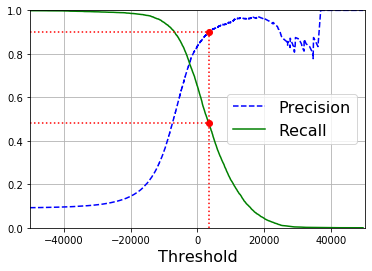

In [36]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") 
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

ROC Curve (Reciever Operating Curve)

In [39]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

In [40]:
#Plottign the roc curve using matplotlib
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr,tpr,linewidth=2,label = label)
    plt.plot([0,1],[0,1],'k--') #dashed diagnol
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive rate',fontsize=16)
    plt.ylabel('True Positive rate',fontsize=16)
    plt.grid(True)
    

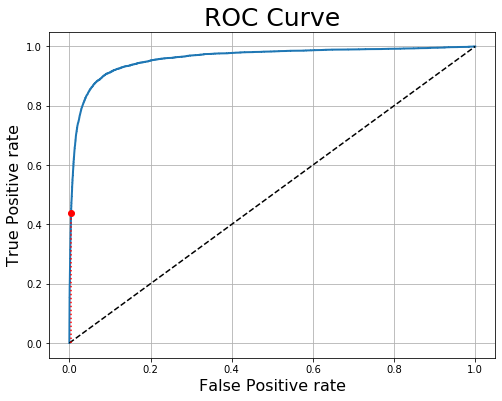

In [47]:
plt.figure(figsize=(8, 6))                       
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
plt.grid(True)      
plt.xlabel('False Positive rate',fontsize=16)
plt.ylabel('True Positive rate',fontsize=16)
plt.title('ROC Curve',fontsize=25)
plt.show()

One way to compare ROC curves is using the area under curve

In [48]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method = 'predict_proba')

In [55]:
y_probas_forest[:,1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [59]:
y_scores_forest = y_probas_forest[:,1]#Get only the probability of the positive class
fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_scores_forest)

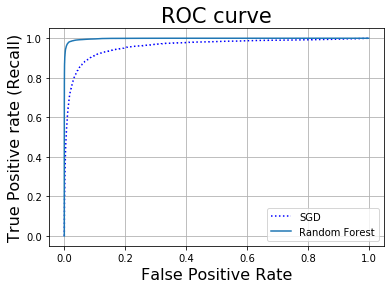

In [62]:
plt.plot(fpr,tpr,'b:',label='SGD')
plt.plot(fpr_forest,tpr_forest,label='Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive rate (Recall)',fontsize=16)
plt.title('ROC curve',fontsize=21)
plt.show()

In [63]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [65]:
#Precsion and recall for randomforest classifier
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print('Precision ',precision_score(y_train_5,y_train_pred_forest))
print('Recall ',recall_score(y_train_5,y_train_pred_forest))

Precision  0.9905083315756169
Recall  0.8662608374838591


### Multiclass Classification

> Some algorithams such as Logistic Regression Classifiers, Random Forest Classifiers and Naive Bayer Classifier are capable of handling multiple classes natively.<br>
> But SGD Classifiers or Support Vector Machine Classifiers are strictly binary classifiers.

In [67]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [68]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [69]:
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[0 1 2 3 4 5 6 7 8 9]
5


In [70]:
#We will evaluate the model using cross-validation
cross_val_score(svm_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.977 , 0.9738, 0.9739])

We have got a good accuracy let us see if we can increase this by scaling the data

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(svm_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.9596, 0.9602, 0.961 ])

### Plotting the confusion matrix for sgd_clf

In [74]:
y_train_pred = cross_val_predict(svm_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5809,    3,   20,    8,    6,   13,   32,   14,   17,    1],
       [   1, 6620,   37,   12,   11,    0,    7,   31,   13,   10],
       [  20,   18, 5721,   42,   27,    4,   20,   61,   36,    9],
       [   3,   15,   83, 5778,    5,   64,    2,   87,   73,   21],
       [   5,   11,   45,    2, 5623,    6,   21,   25,   10,   94],
       [  14,   11,   16,   77,   17, 5134,   58,   50,   28,   16],
       [  20,    7,   22,    0,   13,   39, 5743,   55,   19,    0],
       [   9,   24,   37,   15,   39,    1,    0, 6070,    5,   65],
       [  19,   44,   42,   50,   20,   52,   26,   40, 5533,   25],
       [  11,   10,   25,   49,   81,   12,    1,  153,   22, 5585]],
      dtype=int64)

In [76]:
#stardadising the confusion matrix by dividinng by the total number of images in each class
#Which helps to compare error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums

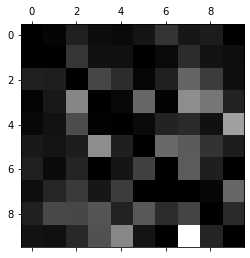

In [77]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

#### Multioutput classification

Here we train a classsifier which outputs labels for each pixel in the sense we denoise the image and generate the cleaned output.

In [82]:
#Lets create some noise
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_test_mod = X_test


                          

In [87]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

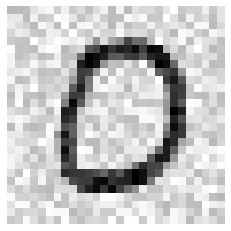

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod,X_train)
clean_digit = knn_clf.predict([X_test_mod[10]])
plot_digit(clean_digit)
plot_digit(X_test_mod[10])

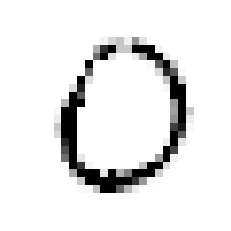

In [95]:
plot_digit(clean_digit)